# Kinematics demo

## Setup

In [1]:
import aopy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import os

sns.set_context('paper')

In [2]:
# import bmi3d db functions to find the data
from bmi3d.db import dbfunctions as db

raw data is located in `/data/raw/`
files include:
* `/data/raw/ecube/2021-07-12_BMI3D_te2001`
* `/data/raw/hdf/beig20210712_te2001.hdf`
* `/data/raw/optitrack/Export/Take 2021-07-12 11_18_19 (2001).csv`


## Preprocessing

In [3]:
data_dir = "/data/raw"
preproc_dir = "/data/preprocessed/beignet"

# find all beignet's 'manual control' files from july 24
task_date = date.fromisoformat('2021-07-24')
entries = db.get_task_entries(subj='beignet', task='manual control', date=task_date)
for e in entries:
    print(e)

2021-07-24 11:33:41.320213: beignet on manual control task, id=2132
2021-07-24 11:35:04.758937: beignet on manual control task, id=2133
2021-07-24 11:37:51.772590: beignet on manual control task, id=2134
2021-07-24 11:41:18.785843: beignet on manual control task, id=2135
2021-07-24 11:47:44.980450: beignet on manual control task, id=2136
2021-07-24 11:49:00.536491: beignet on manual control task, id=2137
2021-07-24 11:52:09.352755: beignet on manual control task, id=2138
2021-07-24 11:56:25.759738: beignet on manual control task, id=2139


In [4]:
# pick number 2139
e = entries[-1]
raw_files = e.get_data_files_dict(data_dir)
preprocessed_filename = "preprocessed_te" + str(e.id) + ".hdf"

# preprocess the experiment data
aopy.preproc.proc_exp(data_dir, raw_files, preproc_dir, preprocessed_filename)

File preprocessed_te2139.hdf already exists, doing nothing.


In [5]:
# load the preprocessed experiment data and metadata
exp_data = aopy.data.load_hdf_group(preproc_dir, preprocessed_filename, 'exp_data')
exp_metadata = aopy.data.load_hdf_group(preproc_dir, preprocessed_filename, 'exp_metadata')
exp_data.keys()

dict_keys(['bmi3d_clock', 'bmi3d_events', 'bmi3d_state', 'bmi3d_task', 'bmi3d_trials', 'clock', 'events', 'measure_clock_offline', 'measure_clock_online', 'reward_system', 'state', 'sync_clock', 'sync_events', 'task', 'trials'])

In [6]:
exp_data['task'].dtype

dtype([('cursor', '<f8', (3,)), ('sync_square', '?', (1,)), ('manual_input', '<f8', (3,)), ('trial', '<u4', (1,)), ('plant_visible', '?', (1,))])

In [7]:
cursor_kinematics = exp_data['task']['cursor'][:,[0,2]] # cursor (x, z, y) position on each bmi3d cycle
hand_kinematics = exp_data['task']['manual_input'] # hand kinematics (x, y, z) in Optitrack coordinates received by bmi3d before transformation to 2D
time = exp_data['clock']['timestamp']

## Plot all kinematic data

Text(0.5, 0.92, 'Hand kinematics in 3D space')

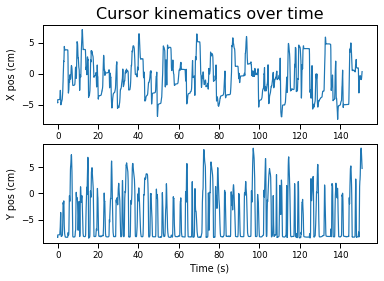

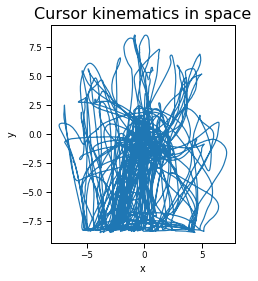

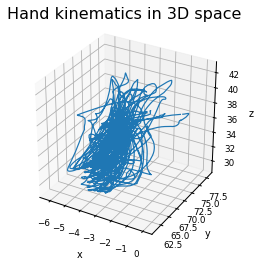

In [8]:
fig, ax = plt.subplots(2,1)
ax[0].plot(time, cursor_kinematics[:, 0])
ax[0].set_ylabel('X pos (cm)')
ax[1].plot(time, cursor_kinematics[:, 1])
ax[1].set_ylabel('Y pos (cm)')
ax[1].set_xlabel('Time (s)')
ax[0].set_title('Cursor kinematics over time', fontsize=16)

fig, ax = plt.subplots(1,1)
aopy.visualization.plot_trajectories([cursor_kinematics])
ax.set_title('Cursor kinematics in space', fontsize=16)

fig = plt.figure()
ax = plt.axes(projection='3d')
aopy.visualization.plot_trajectories([hand_kinematics])
ax.set_title('Hand kinematics in 3D space', fontsize=16)

## Separate trajectories by trial

In [9]:
CENTER_TARGET_ON = 16
CURSOR_ENTER_CENTER_TARGET = 80
CENTER_TARGET_OFF = 32
REWARD = 48
DELAY_PENALTY = 66
TIMEOUT_PENALTY = 65
HOLD_PENALTY = 64
TRIAL_END = 239

In [10]:
clock = exp_data['clock']
print(clock.dtype)
events = exp_data['events']
print(events.dtype)

[('time', '<u8'), ('timestamp', '<f8'), ('prev_tick', '<f8'), ('timestamp_bmi3d', '<f8'), ('timestamp_sync', '<f8'), ('timestamp_measure_offline', '<f8')]
[('time', '<u8'), ('event', 'S32'), ('data', '<u4'), ('code', 'u1'), ('timestamp_bmi3d', '<f8'), ('timestamp_sync', '<f8'), ('timestamp', '<f8')]


In [23]:
event_names = events['event']
event_cycles = events['time'] # confusingly, 'time' here refers to cycle count
trial_segments, trial_times = aopy.preproc.get_trial_segments(events['code'], event_cycles, [CURSOR_ENTER_CENTER_TARGET], [REWARD, HOLD_PENALTY, DELAY_PENALTY])
trial_segments = np.array(trial_segments)
print(trial_segments[:10])
print(trial_times[:10])

[array([80, 23, 32, 87, 48], dtype=uint8)
 array([80, 18, 32, 82, 48], dtype=uint8)
 array([80, 24, 32, 88, 64], dtype=uint8)
 array([80, 24, 32, 88, 48], dtype=uint8)
 array([80, 17, 32, 81, 64], dtype=uint8)
 array([80, 17, 32, 81, 48], dtype=uint8)
 array([80, 21, 32, 85, 48], dtype=uint8)
 array([80, 22, 32, 86, 48], dtype=uint8)
 array([80, 19, 32, 83, 48], dtype=uint8)
 array([80, 20, 32, 84, 48], dtype=uint8)]
[[ 318  395]
 [ 684  781]
 [1086 1162]
 [1340 1438]
 [1700 1775]
 [1934 2016]
 [2345 2424]
 [2755 2835]
 [3118 3202]
 [3473 3602]]


<ipython-input-23-54ba22744526>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  trial_segments = np.array(trial_segments)


In [24]:
trial_indices = [range(t[0], t[1]) for t in trial_times]
cursor_trajectories = [cursor_kinematics[t] for t in trial_indices]
hand_trajectories = [hand_kinematics[t] for t in trial_indices]

In [25]:
# get the unique target positions
trials = exp_data['trials']
n_trials = len(trials)
trial_targets = aopy.postproc.get_trial_targets(trials['trial'], trials['target'][:,[0,2]]) # (x, z, y) -> (x, y)
unique_targets = np.unique(np.concatenate(([t[1] for t in trial_targets], trial_targets[0])), axis=0)

## Plot 50 trial trajectories

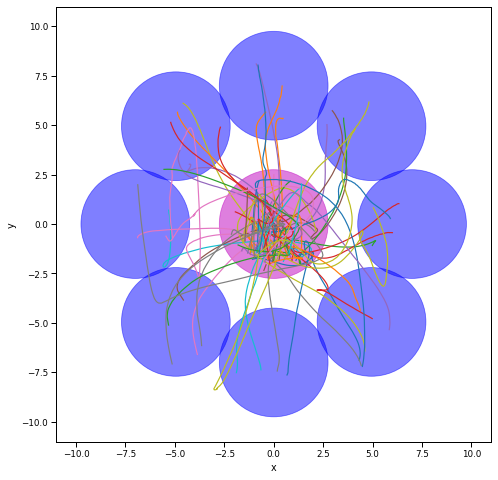

In [26]:
fig, ax = plt.subplots(figsize=(8,8))
bounds = exp_metadata['cursor_bounds'][[0,1,4,5]]
aopy.visualization.plot_trajectories(cursor_trajectories, bounds=bounds)
aopy.visualization.plot_targets(unique_targets, exp_metadata['target_radius'])

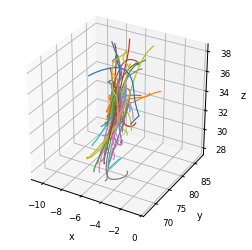

In [27]:
bounds_3d = [-10, 0, 60, 80, 25, 35]
fig = plt.figure()
ax = plt.axes(projection='3d')
aopy.visualization.plot_trajectories(hand_trajectories[:50], bounds=bounds_3d)